# Vessel Emissions API Use Case

## Run this example in [Colab](https://colab.research.google.com/github/SignalOceanSdk/SignalSDK/blob/master/docs/examples/jupyter/VesselEmissionsAPI/Carbon%20Analysis.ipynb)

# Carbon analysis

### In this notebook, we will show a use case of visualizing carbon emissions and metrics for a fleet.
### We will choose our fleet as a list of vessels, get their historical voyage emissions using Signal Ocean's Vessel Emissions APIn and plot CO2 emissions and CII for the previous and current year.

## Setup

Install the Signal Ocean SDK:
```
pip install signal-ocean
```
Set your subscription key acquired here: https://apis.signalocean.com/profile


In [1]:
!pip install signal-ocean

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 kB 2.7 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.2
    Uninstalling typeguard-4.4.2:
      Successfully uninstalled typeguard-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


### Initialize Vessel Emissions API

In [2]:
!pip install signal-ocean
signal_ocean_api_key = '' #replace with your subscription key

from signal_ocean import Connection
from signal_ocean.vessel_emissions import VesselEmissionsAPI

connection = Connection(signal_ocean_api_key)
emissions_api = VesselEmissionsAPI(connection)

### Import helpful modules

In [3]:
from datetime import date, timedelta
from tqdm import tqdm

import requests
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
import numpy as np
sns.set_theme()
sns.set_style("whitegrid")

## Input Data

### Choose a fleet as list of IMOs.

In [4]:
vessel_imos = [ 9299111, 9314193, 9411197, 9425526, 9440473, 9459096, 9461659, 9462354, 9486922, 9486934, 9487469, 9487471, 9487483, 9505819,
               9524982, 9543536, 9580405, 9688336, 9688348, 9723007, 9726619, 9767340, 9773947, 9780251, 9783992, 9833723 ]

### Use the emissions api to get historical emissions and metrics data for the list of selected vessels, including EU emissions. We will store the data as pandas dataframe and keep only data from 2023 and on.

In [5]:
emissions_list = []
metrics_list = []

for imo in tqdm(vessel_imos):
    vessel_emissions = emissions_api.get_emissions_by_imo(imo)
    vessel_emissions = [emissions.to_dict() for emissions in vessel_emissions]
    emissions_list.extend(vessel_emissions)
    vessel_metrics = emissions_api.get_metrics_by_imo(imo)
    vessel_metrics = [metrics.to_dict() for metrics in vessel_metrics]
    metrics_list.extend(vessel_metrics)

emissions_df = pd.json_normalize(emissions_list, sep='')
emissions_df = emissions_df[emissions_df['StartDate'] >= '2023']
metrics_df = pd.json_normalize(metrics_list, sep='')
metrics_df = metrics_df[metrics_df['Year'] >= 2023]

100%|██████████| 26/26 [00:55<00:00,  2.13s/it]


In [6]:
emissions_df.groupby("VesselClass")['EmissionsVoyageCO2InTons'].mean()

,EmissionsVoyageCO2InTons
VesselClass,
Aframax,1432.394487
MR1,719.735044
MR2,605.297518
Panamax,850.613621
Suezmax,1671.113432


### In the next plots we see total CO2 emissions per vessel for the previous and current year, and for 2023 and 2024 separately.

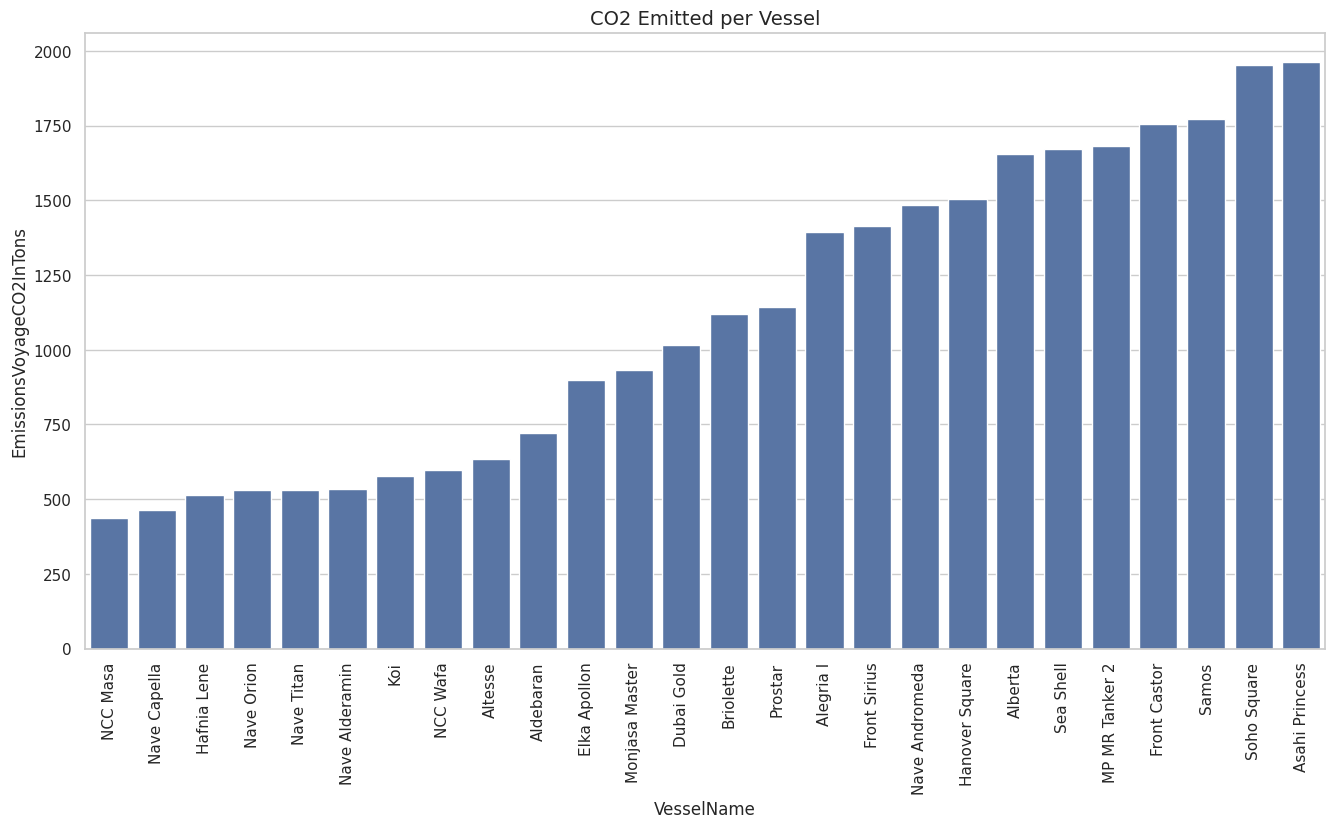

In [7]:
emissions_per_vessel = emissions_df.groupby("VesselName")['EmissionsVoyageCO2InTons'].mean().reset_index()
plt.figure(figsize=(16,8))
emissions_per_vessel.sort_values('EmissionsVoyageCO2InTons', inplace=True)
sns.barplot(x='VesselName', y='EmissionsVoyageCO2InTons', data=emissions_per_vessel)
plt.xticks(rotation=90)
plt.title('CO2 Emitted per Vessel', fontsize=14)
plt.show()

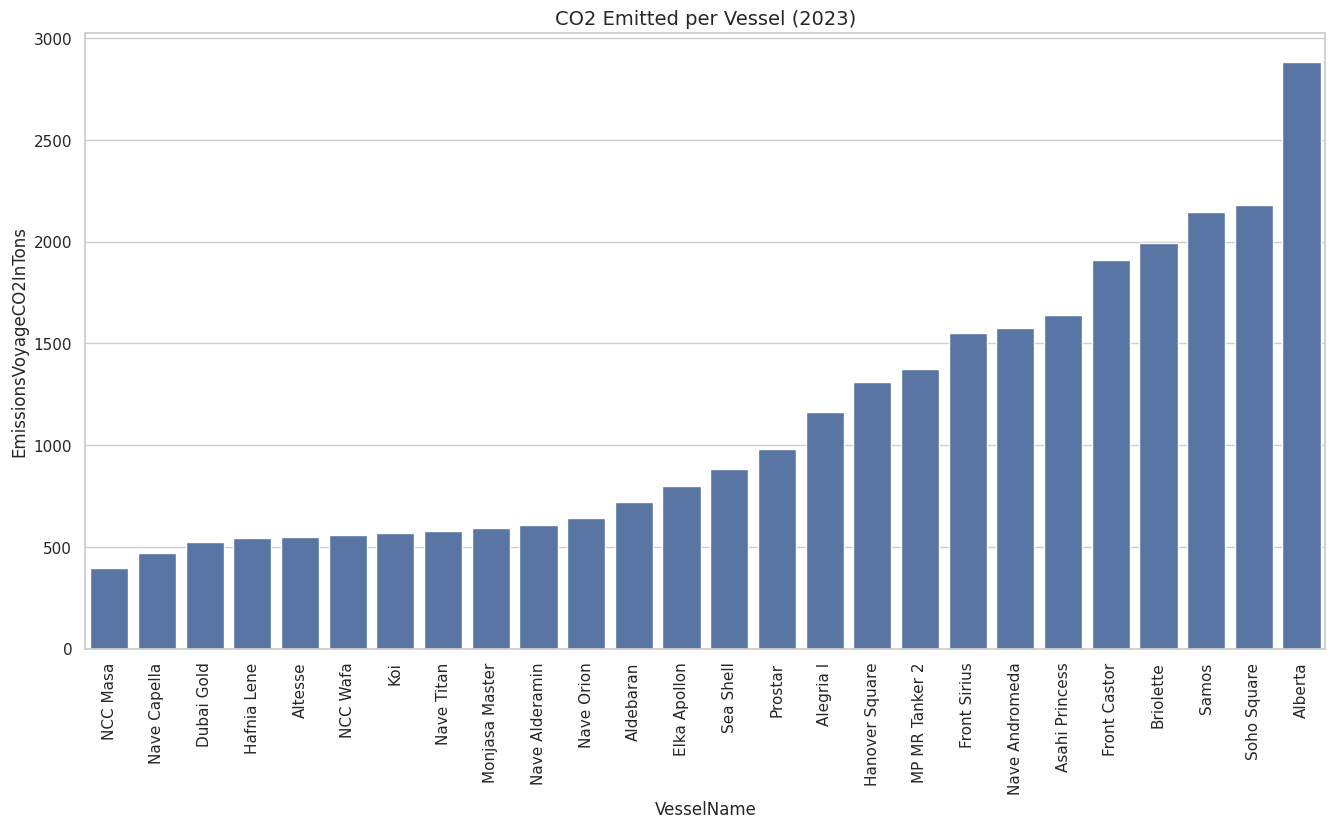

In [8]:
emissions_per_vessel_2023 = emissions_df[emissions_df['EndDate'] < "2024"].groupby("VesselName")['EmissionsVoyageCO2InTons'].mean().reset_index()
plt.figure(figsize=(16,8))
emissions_per_vessel_2023.sort_values('EmissionsVoyageCO2InTons', inplace=True)
sns.barplot(x='VesselName', y='EmissionsVoyageCO2InTons', data=emissions_per_vessel_2023)
plt.xticks(rotation=90)
plt.title('CO2 Emitted per Vessel (2023)', fontsize=14)
plt.show()

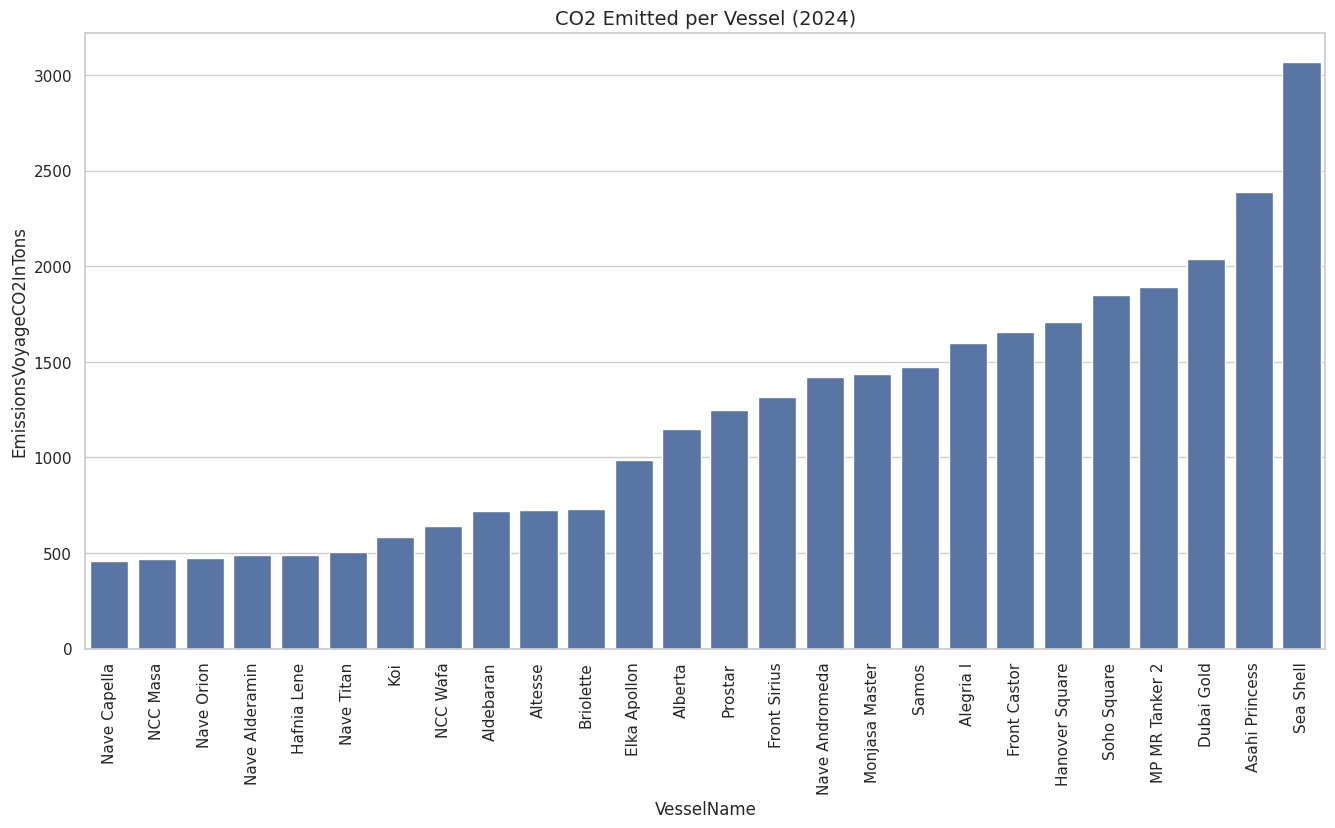

In [9]:
emissions_per_vessel_2024 = emissions_df[emissions_df['EndDate'] >= "2024"].groupby("VesselName")['EmissionsVoyageCO2InTons'].mean().reset_index()
plt.figure(figsize=(16,8))
emissions_per_vessel_2024.sort_values('EmissionsVoyageCO2InTons', inplace=True)
sns.barplot(x='VesselName', y='EmissionsVoyageCO2InTons', data=emissions_per_vessel_2024)
plt.xticks(rotation=90)
plt.title('CO2 Emitted per Vessel (2024)', fontsize=14)
plt.show()

### We can also color our plot with vessel class.

In [10]:
emissions_per_class = emissions_df.groupby("VesselName").agg(
    CO2_Emissions=("EmissionsVoyageCO2InTons", "mean"), Number_of_Voyages=("VoyageNumber","size"), VesselClass=("VesselClass", "first")).reset_index()

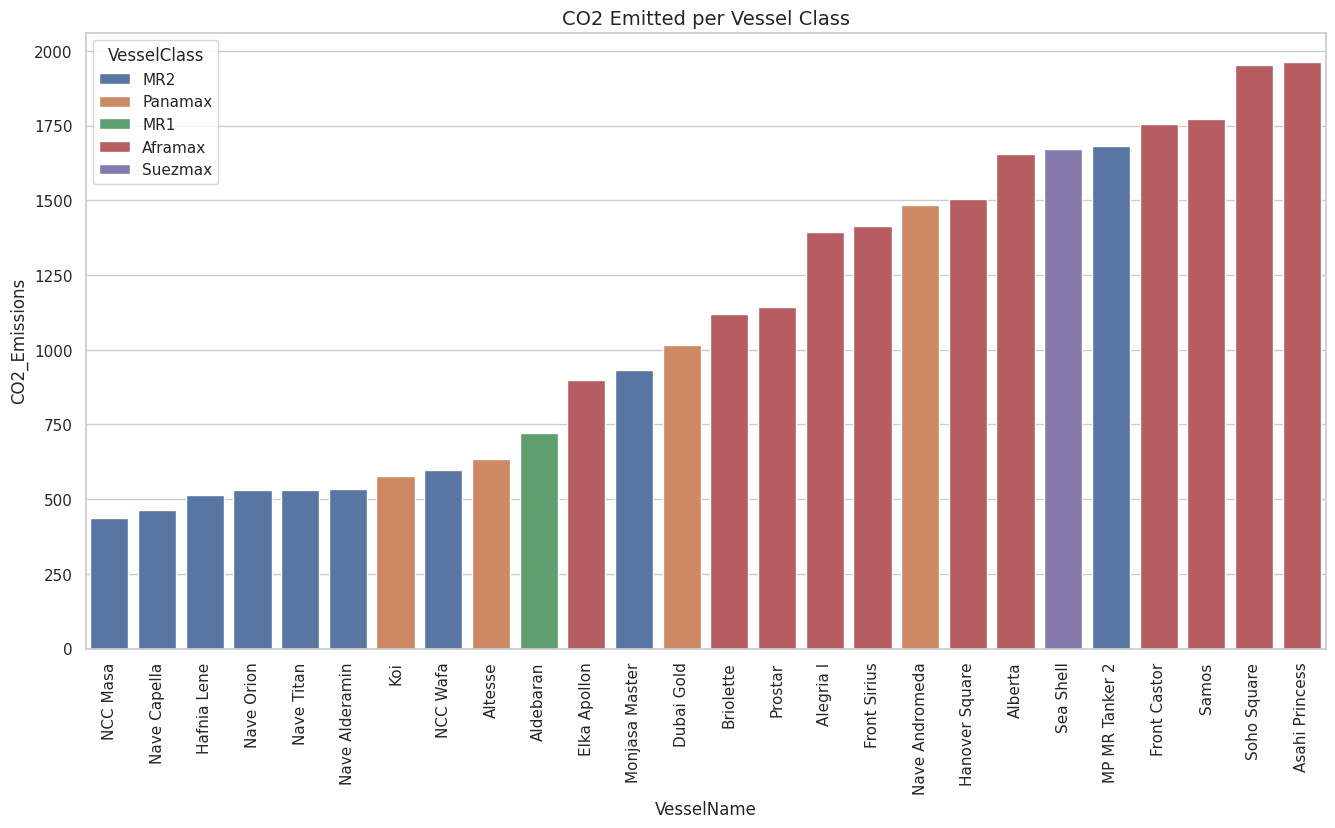

In [11]:
plt.figure(figsize=(16,8))
emissions_per_class.sort_values('CO2_Emissions', inplace=True)
ax = sns.barplot(x='VesselName', y='CO2_Emissions', hue='VesselClass', data=emissions_per_class)
# ax.bar_label(ax.containers[0], labels=emissions_per_vessel_2023['Number_of_Voyages'])
plt.xticks(rotation=90)
plt.title('CO2 Emitted per Vessel Class', fontsize=14)
plt.show()

### We repeat for the metrics data, using CII.

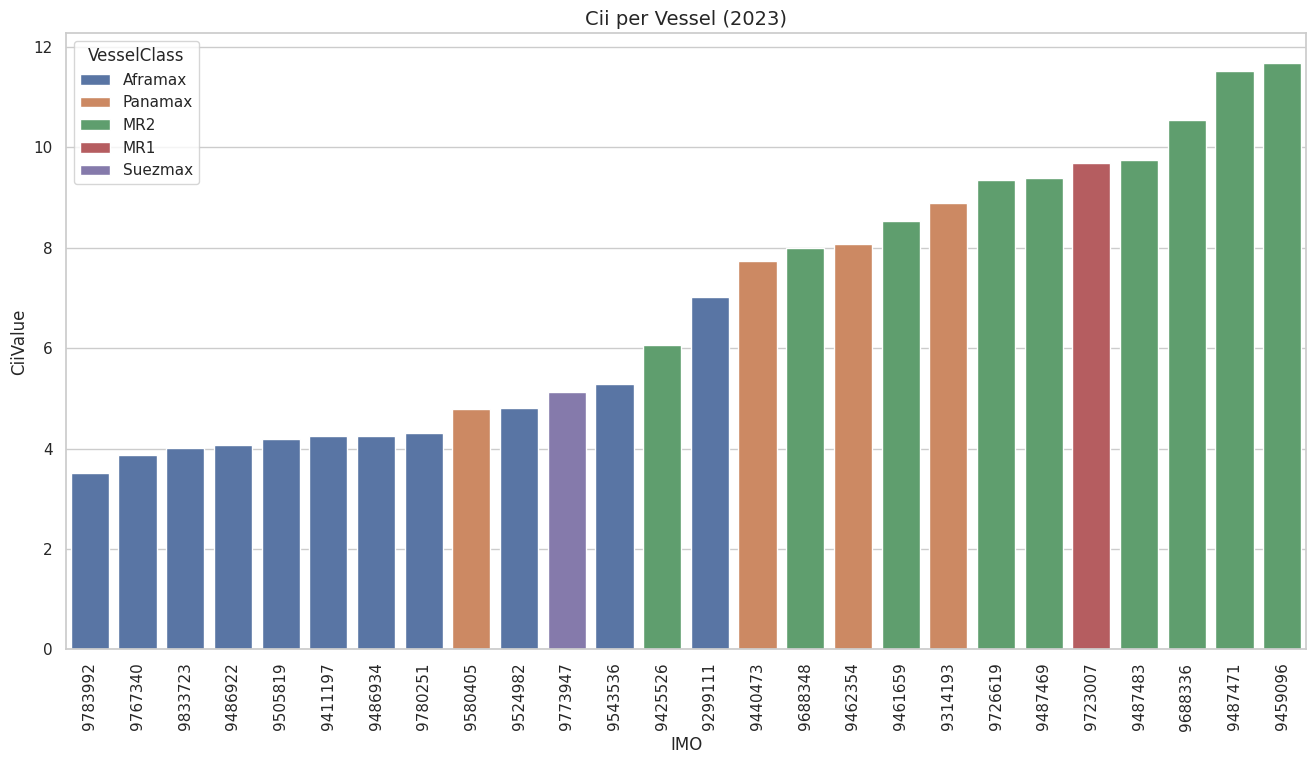

In [12]:
metrics_2023 = metrics_df[metrics_df['Year']==2023].copy()

plt.figure(figsize=(16,8))
metrics_2023.sort_values('CiiValue', inplace=True)
ax = sns.barplot(x='IMO', y='CiiValue', hue='VesselClass', data=metrics_2023, order=metrics_2023.IMO)
plt.xticks(rotation=90)
plt.title('Cii per Vessel (2023)', fontsize=14)
plt.show()

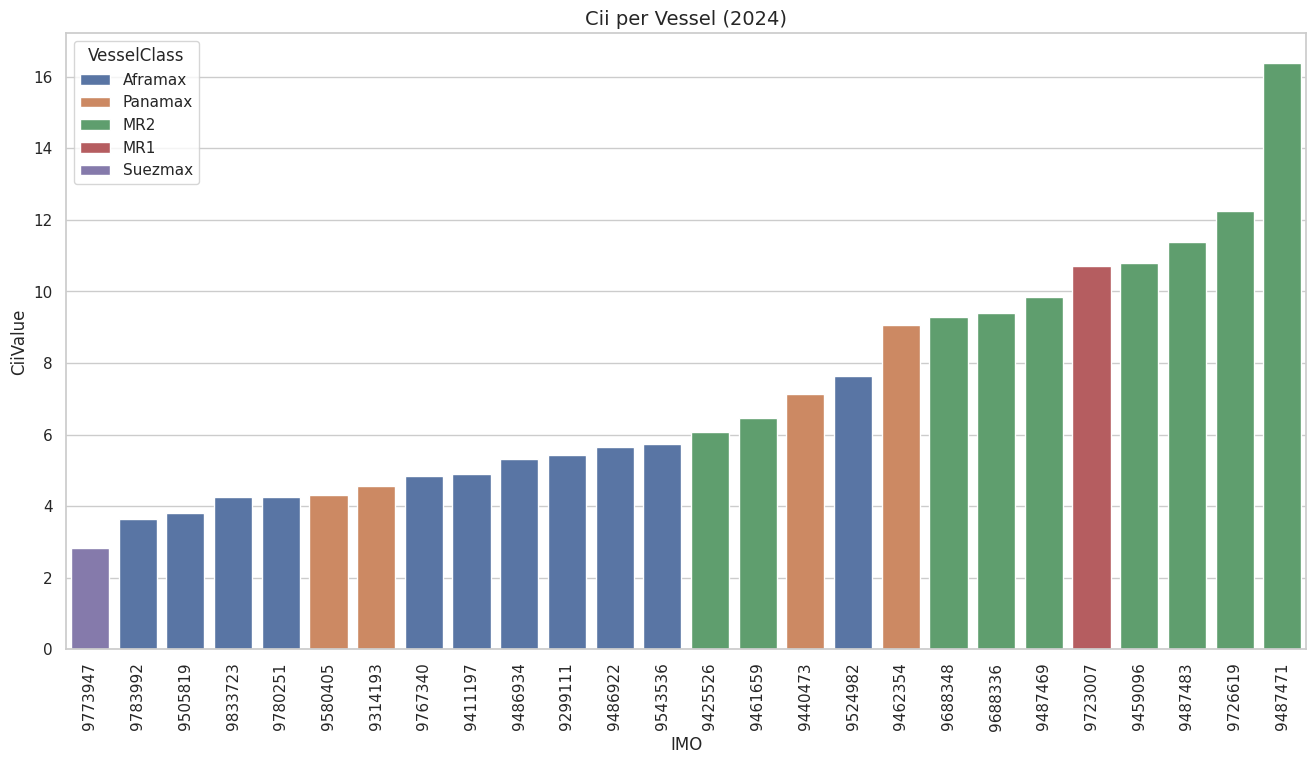

In [13]:
metrics_2024 = metrics_df[metrics_df['Year']==2024].copy()

plt.figure(figsize=(16,8))
metrics_2024.sort_values('CiiValue', inplace=True)
ax = sns.barplot(x='IMO', y='CiiValue', hue='VesselClass', data=metrics_2024, order=metrics_2024.IMO)
plt.xticks(rotation=90)
plt.title('Cii per Vessel (2024)', fontsize=14)
plt.show()